# Train a deep neural network on the CIFAR10 dataset
---

## What I learned ?
- blabla
- blabla 
- blabla

## Summary
1. Load the CIFAR10 dataset
2. Build the DNN
3. Use Nadam optimization and early stopping
4. Add batch normalization and compare the learning curves
5. Replace Batch Normalization with SELU
6. Regularize the model with alpha dropout. Then with MC dropout
7. Retrain your model using 1cycle scheduling

## Setup

In [192]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorboard
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

## 1. Load the CIFAR10 dataset
---
The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.

In [193]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

### Split the training set

In [194]:
from sklearn.model_selection import train_test_split 
test_size = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [195]:
# summary
print(f"Training shape\nX→{X_train.shape}\ny→{y_train.shape}")
print("")
print(f"Validation shape\nX→{X_val.shape}\ny→{y_val.shape}")
print("")
print(f"Testing set\nX→{X_test.shape}\ny→{y_test.shape}")

Training shape
X→(45000, 32, 32, 3)
y→(45000, 1)

Validation shape
X→(5000, 32, 32, 3)
y→(5000, 1)

Testing set
X→(10000, 32, 32, 3)
y→(10000, 1)


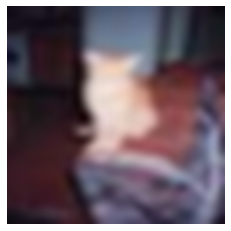

In [196]:
def show_image(image):
    plt.imshow(image, interpolation="lanczos")
    plt.axis("off")
    
show_image(X_train[0])
plt.show()

↳ It is a cat! 

In [197]:
# As each label is a digit, we create a list to point each digit to its corresponding classe:
cifar10_class = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Let's take a look at multiple instances

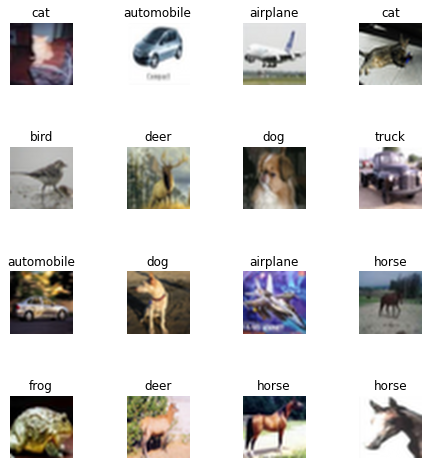

In [198]:
n_rows = 4
n_columns = 4
plt.figure(figsize=(n_columns * 2, n_rows * 2))
for row in range(n_rows):
    for column in range(n_columns):
        index = row * n_rows + column
        plt.subplot(n_rows, n_columns, index + 1)
        show_image(X_train[index])
        plt.title(cifar10_class[y_train[index][0]])
plt.subplots_adjust(wspace=0.2, hspace=1)
plt.show()

## 2. Build and Train the DNN
---
Build a DNN with 20 hidden layers of 100 neurons each. 

#### A. Build the model (He initialization & ELU activation function)

In [199]:
def deep_model(n_layers=20, n_neurons=100):
    model = keras.models.Sequential([])
    model.add(keras.layers.Flatten(input_shape=[32,32,3]))
    for h in range(n_layers):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer="he_normal", activation="elu"))
    keras.layers.Dense(10, activation="softmax")
    return model

In [200]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = deep_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               307300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

#### B. Add Tensorboard, Early Stopping and Checkpoint

create the directory which will be use by TensorBoard

In [201]:
import os
import time
root_logdir = os.path.join(os.curdir,"tensorboard_files")
run_logdir = os.path.join(root_logdir, "default")

We are using 3 callbacks:

- __Early Stopping__, to stop the training on the best epochs
- __Model Checkpoint__, to save and keep the best model
- __TensorBoard__, to visualize the learning curves of the different run

In [202]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("saved_model/my_model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

#### C. Compile and Train the Model with Nadam opti

In [207]:
# compile 
Nadam_opt = keras.optimizers.Nadam(lr=5e-5)
model.compile(optimizer=Nadam_opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# train
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                   callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 8.6025 - accuracy: 0.0000e+00 - val_loss: 8.4265 - val_accuracy: 0.0000e+00
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 8.3547 - accuracy: 0.0000e+00 - val_loss: 8.4296 - val_accuracy: 0.0000e+00
Epoch 3/100
1407/1407 [==============================] - 9s 7ms/step - loss: 8.3347 - accuracy: 0.0000e+00 - val_loss: 8.3996 - val_accuracy: 0.0000e+00
Epoch 4/100
1407/1407 [==============================] - 9s 7ms/step - loss: 8.3031 - accuracy: 0.0000e+00 - val_loss: 8.3689 - val_accuracy: 0.0000e+00
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 8.2936 - accuracy: 0.0000e+00 - val_loss: 8.3689 - val_accuracy: 0.0000e+00
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 8.2936 - accuracy: 0.0000e+00 - val_loss: 8.3689 - val_accuracy: 0.0000e+00
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 8.2

In [203]:
X_train.shape

(45000, 32, 32, 3)

In [204]:
X_valid.shape

(5000, 32, 32, 3)

In [205]:
y_train.shape

(45000, 1)

In [206]:
y_valid.shape

(5000, 1)

In [208]:
y_valid

array([[6],
       [9],
       [9],
       ...,
       [5],
       [4],
       [6]], dtype=uint8)